In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
freqs = pd.read_csv('loop_freqs.csv')

In [3]:
freqs.shape

(193100, 8)

In [4]:
freqs.groupby('File').Read_count.mean()

File
p10-km1.freqs     2039.805321
p10-km2.freqs     1598.280887
p10-km3.freqs     3828.880952
p3-km1           10979.864724
p3-km1.freqs      1821.680434
p3-km2.freqs      3397.971728
p3-km3.freqs      3400.860711
p7-km1.freqs      5442.029774
p7-km2.freqs      3295.625659
p7-km3.freqs      1907.024668
Name: Read_count, dtype: float64

In [5]:
freqs = freqs[freqs.File!='p3-km1'].copy()  # drop the weird one..

In [6]:
freqs['File'].value_counts()

p7-km1.freqs     19480
p3-km3.freqs     19420
p3-km1.freqs     19370
p10-km3.freqs    19320
p3-km2.freqs     19100
p7-km2.freqs     18980
p10-km1.freqs    18980
p7-km3.freqs     18850
p10-km2.freqs    18495
Name: File, dtype: int64

In [7]:
freqs['km'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[1].replace("km","")).astype(int)

In [8]:
freqs['passage'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[0].replace("p","")).astype(int)

In [9]:
freqs.sort_values(by=['km', 'passage', 'Pos'], inplace=True)

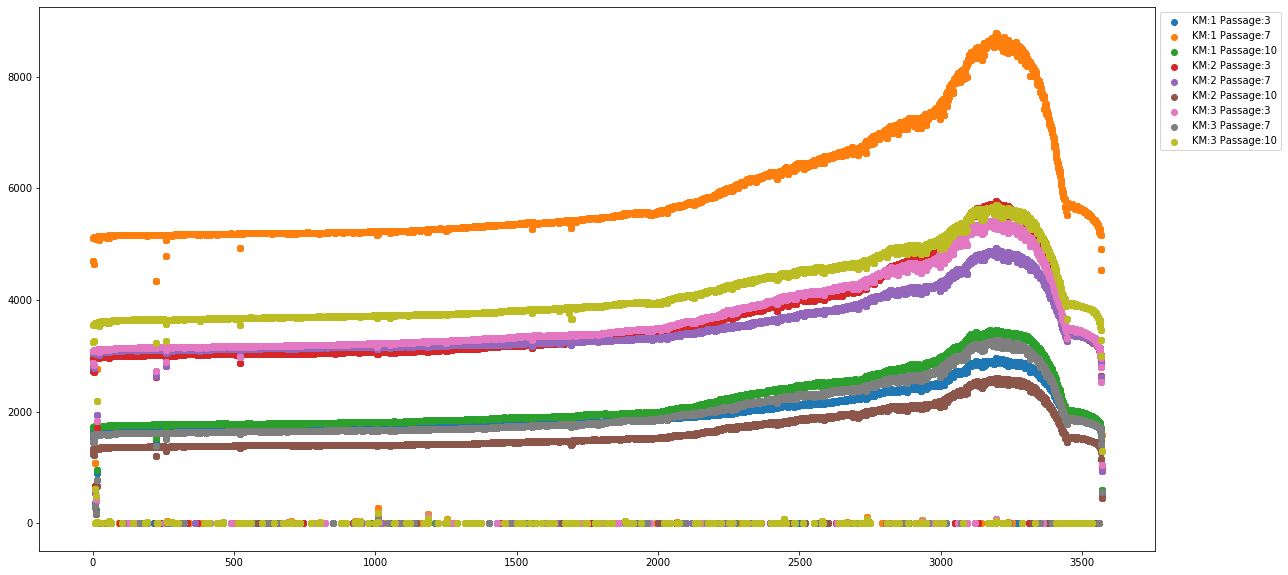

In [10]:
plt.figure(figsize=(20, 10))
for km in freqs.km.unique():
    for pas in freqs.passage.unique():
        df = freqs[freqs.km==km]
        df = df[df.passage==pas]
        plt.scatter(df.Pos, df.Read_count, label=f"KM:{km} Passage:{pas}")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('loop_coverage.png')

In [11]:
def get_mutation_data(freqs):
    mutation_data = freqs[(
        ((freqs.Freq>0.001) & (freqs.Freq<0.5)) | (freqs.Pos!=round(freqs.Pos))) & 
        (freqs.Read_count>50) & 
        (freqs.Pos>=23) & (freqs.Pos<=3549)].copy()
    mutation_data = mutation_data.sort_values(by=['passage'])
    coverages = freqs[['Read_count', 'Pos', 'passage', 'km']].sort_values(by=['km', 'passage', 'Pos']).set_index(['km', 'passage', 'Pos'])
    mutation_data['coverage'] = mutation_data.apply(lambda row: coverages.loc[(row.km, row.passage, round(row.Pos))].Read_count[0], axis=1)
    mutation_data.loc[mutation_data.Ref=="-", "Freq"] = mutation_data.loc[mutation_data.Ref=="-", "Read_count"] * mutation_data.loc[mutation_data.Ref=="-", "Freq"] / mutation_data.loc[mutation_data.Ref=="-", "coverage"]
    return mutation_data[(mutation_data.Freq>0.001) & (mutation_data.Freq<0.5)]

In [12]:
def mutation_time_series(df, ax, colors_dict, going=None):
    x = df.passage
    y = df.Freq
    if going=='up':
        if y.iloc[0] >= y.iloc[-1]*0.7:
            return
    if going=='down':
        if y.iloc[0] <= y.iloc[-1]*0.7:
            return
    label = f"{df.Pos.iloc[0]}{df.Base.iloc[0]}"
    if label in colors_dict.keys():
        color = colors_dict[label]
        alpha = 1
    else:
        color = 'black'
        label = None
        alpha = 0.1
    ax.plot(df.passage, df.Freq, color=color, label=label, alpha=alpha)
    return ax
    #ax.text(x.iloc[-1], y.iloc[-1], label)

In [13]:
def muts_overview(data, ax):
    plt.figure(figsize=(20, 10))
    base_color = {'A': 'red', 
                  'G': 'blue', 
                  'C': 'orange', 
                  'T': 'green', 
                  '-': 'black'}
    for letter in data.Base.unique():
        letter_df = data[data.Base==letter]
        for phase in letter_df.passage.unique():
            phase_df = letter_df[letter_df.passage==phase]
            y = phase_df[f'Freq']
            ax.scatter(phase_df.Pos, y, label=f"{letter}{phase}", color=base_color[letter], alpha=1.1-(int(phase)/10))
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylim([-0.02,0.53])
    ax.set_xlabel('Postion')
    ax.set_ylabel('Frequency')
    return ax

Getting Mutation Data...
Creating graphs!


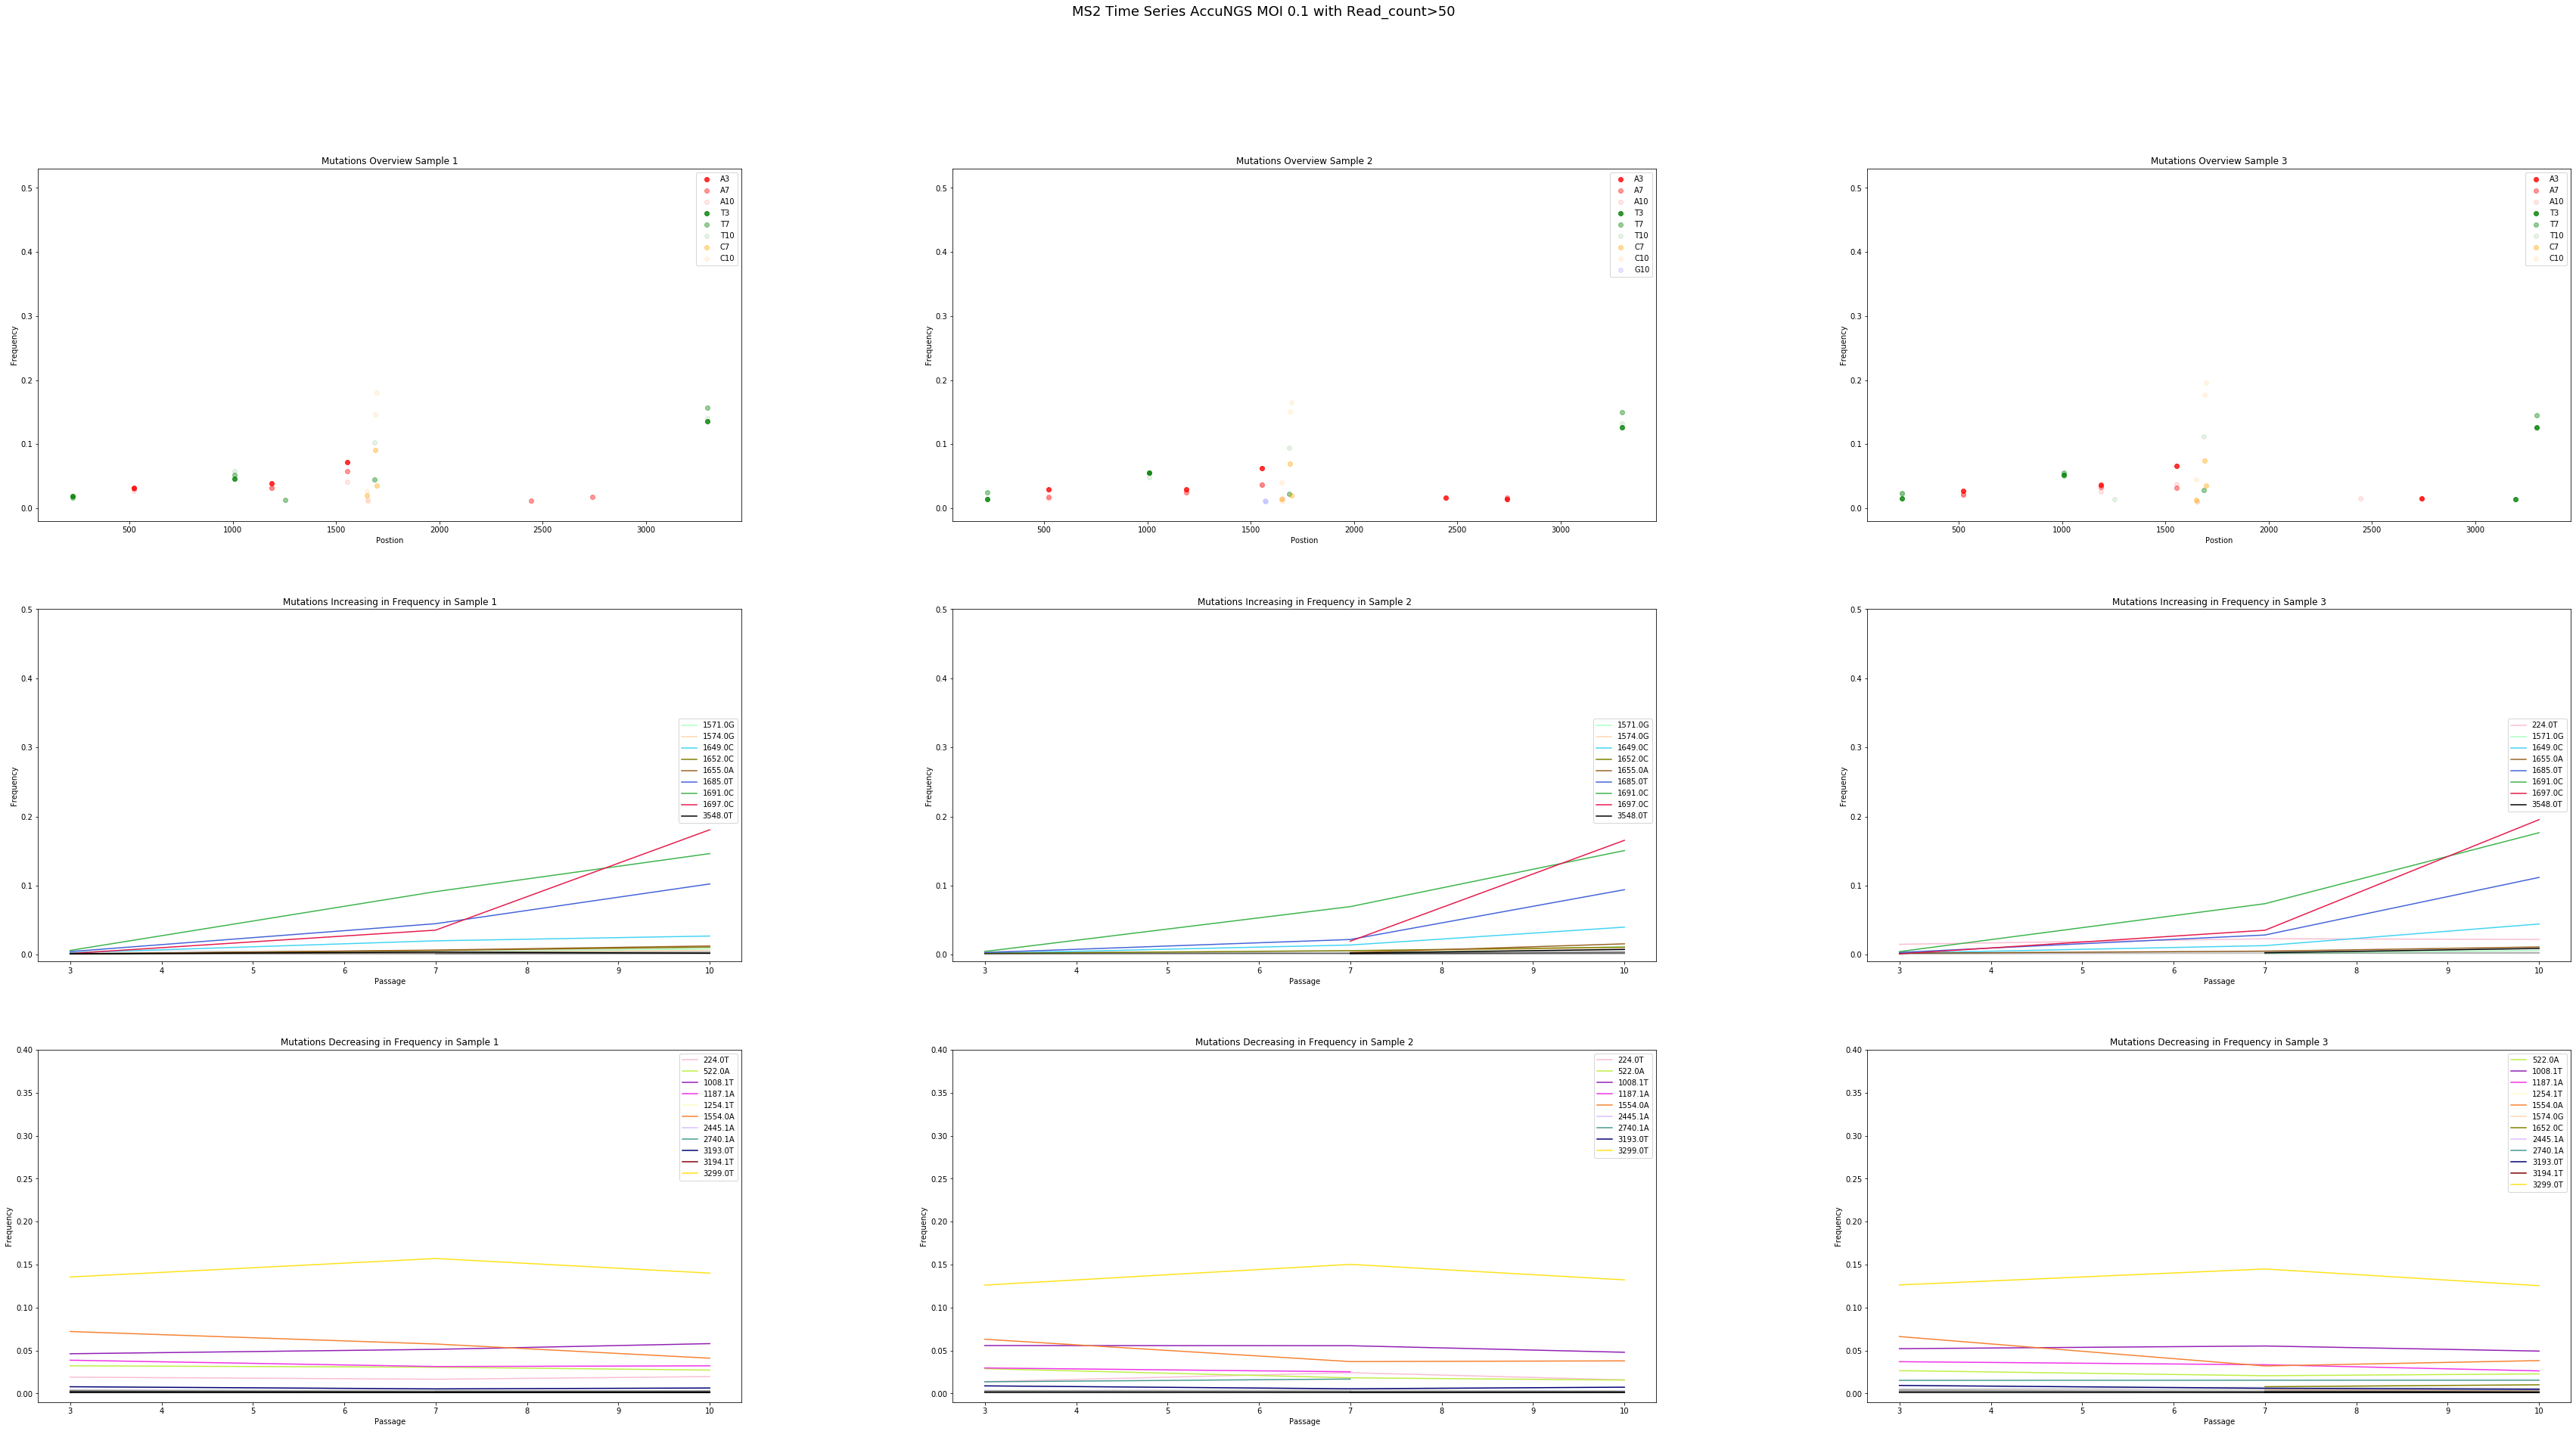

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [14]:
fig, axes = plt.subplots(figsize=(60, 30), ncols=3, nrows=3)
plt.suptitle("MS2 Time Series AccuNGS MOI 0.1 with Read_count>50", fontsize=18)
plt.subplots_adjust(wspace=0.3, hspace=0.25)
print("Getting Mutation Data...")
mutation_data = get_mutation_data(freqs)
top_mutations = mutation_data.groupby(['Pos','Base']).Freq.max().sort_values(ascending=False).head(20).index
top_mutations = [f'{pos}{base}' for (pos, base) in top_mutations]
color_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', 
              '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
              '#000075', '#000000']
color_dict = {top_mutations[i]: color_list[i] for i in range(len(top_mutations))}
print("Creating graphs!")

for i in range(3):
    km_muts = mutation_data[mutation_data.km==i+1]
    axes[0][i] = muts_overview(km_muts[km_muts.Freq>0.01], axes[0][i])
    axes[0][i].set_title(f"Mutations Overview Sample {i+1}")
    km_muts.groupby(['Pos', 'Base']).apply(
        lambda df: mutation_time_series(df, axes[1][i], color_dict, going='up'))
    axes[1][i].set_ylim([-0.01,0.5])
    axes[1][i].legend(bbox_to_anchor=(1, 0.7))
    axes[1][i].set_title(f"Mutations Increasing in Frequency in Sample {i+1}")
    axes[1][i].set_xlabel('Passage')
    axes[1][i].set_ylabel('Frequency')
    km_muts.groupby(['Pos', 'Base']).apply(
        lambda df: mutation_time_series(df, axes[2][i], color_dict, going='down'))
    axes[2][i].set_ylim([-0.01,0.4])
    axes[2][i].set_xlabel('Passage')
    axes[2][i].set_ylabel('Frequency')
    axes[2][i].set_title(f"Mutations Decreasing in Frequency in Sample {i+1}")
    axes[2][i].legend(bbox_to_anchor=(1, 1))


In [15]:
fig.savefig('loop_overview.png')